In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import find_peaks

# Preprocess stock data function
def preprocess_stock_data(csv_file_path):
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)

    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)

    data["Volume"] = data["Volume"].apply(convert_volume_to_number)

    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        new_change = float(change_str.strip('%')) / 100
        return new_change

    data["Change %"] = data["Change %"].apply(convert_change_to_number)

    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))

    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data

In [87]:
def split_data(data, train_size, test_size):
    if (train_size + test_size) > 1.0:
        raise ValueError("The sum of train and test sizes must not exceed 1.0")
    train_size = int(train_size * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

In [88]:
def fft_train(data, percentile_threshold):
    close_prices = data['Close'].values
    close_prices_fft = fft(close_prices)
    power_spectrum = np.abs(close_prices_fft)
    threshold = np.percentile(power_spectrum, percentile_threshold)
    significant_freqs = np.where(power_spectrum > threshold)[0]
    
    filtered_fft = np.zeros_like(close_prices_fft)
    filtered_fft[significant_freqs] = close_prices_fft[significant_freqs]
    
    reconstructed_signal = np.real(ifft(filtered_fft))
    return reconstructed_signal, significant_freqs, close_prices_fft, power_spectrum, threshold

In [89]:
def fft_predict(data, num_predict, significant_freqs, close_prices_fft):
    n = len(data['Close'].values)
    close_prices = data['Close'].values
    
    # Ensure the prediction length matches the test data length
    future_time_points = np.arange(n, n + num_predict)
    future_signal = np.zeros(num_predict)  # Generate predictions only for the test data length
    
    for freq in significant_freqs:
        amplitude = np.abs(close_prices_fft[freq]) / n
        phase = np.angle(close_prices_fft[freq])
        future_signal += amplitude * np.cos(2 * np.pi * freq * future_time_points / n + phase)
    
    return future_signal


In [90]:
def calculate_metrics(true_values, predictions):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    return rmse, mae, mape

In [91]:

def smooth_signal(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

In [92]:
# Load data
data = preprocess_stock_data('../../DATASET/VHM.csv')
train_data, test_data = split_data(data, 0.9, 0.1)

# Set the percentile threshold
percentile_threshold = 95

# Perform FFT training
reconstructed_signal, significant_freqs, close_prices_fft, power_spectrum, threshold = fft_train(train_data, percentile_threshold)

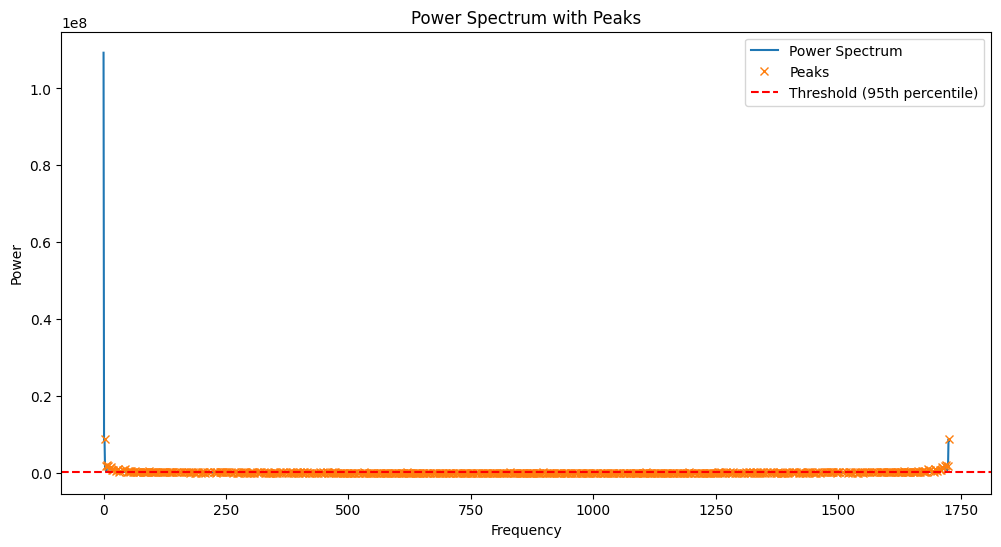

In [93]:
# Plot power spectrum with peaks
plt.figure(figsize=(12, 6))
peaks, _ = find_peaks(power_spectrum)
plt.plot(power_spectrum, label='Power Spectrum')
plt.plot(peaks, power_spectrum[peaks], "x", label='Peaks')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({percentile_threshold}th percentile)')
plt.title('Power Spectrum with Peaks')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.show()

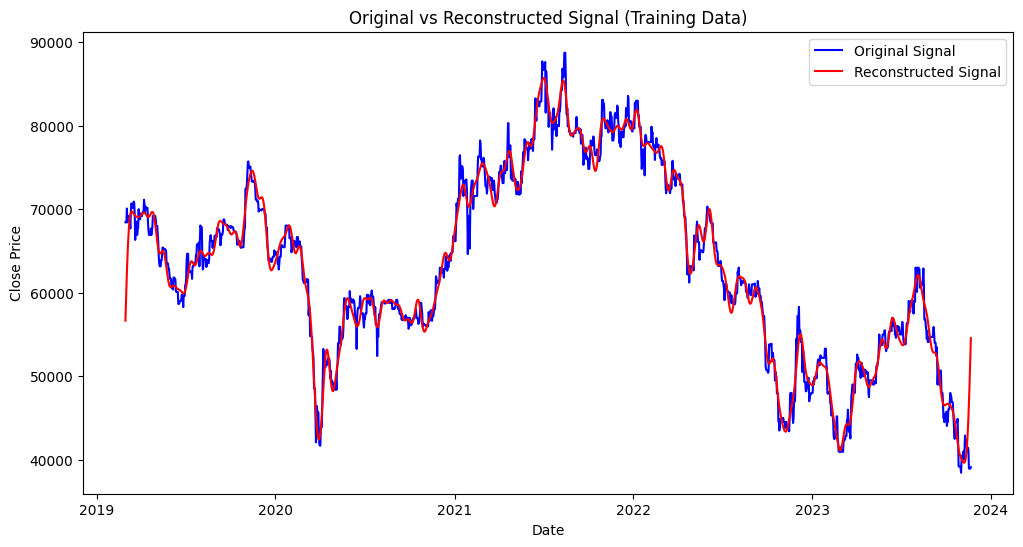

In [94]:
# Plot original vs reconstructed signal on training data
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Original Signal', color='blue')
plt.plot(train_data['Date'], reconstructed_signal, label='Reconstructed Signal', color='red')
plt.title('Original vs Reconstructed Signal (Training Data)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

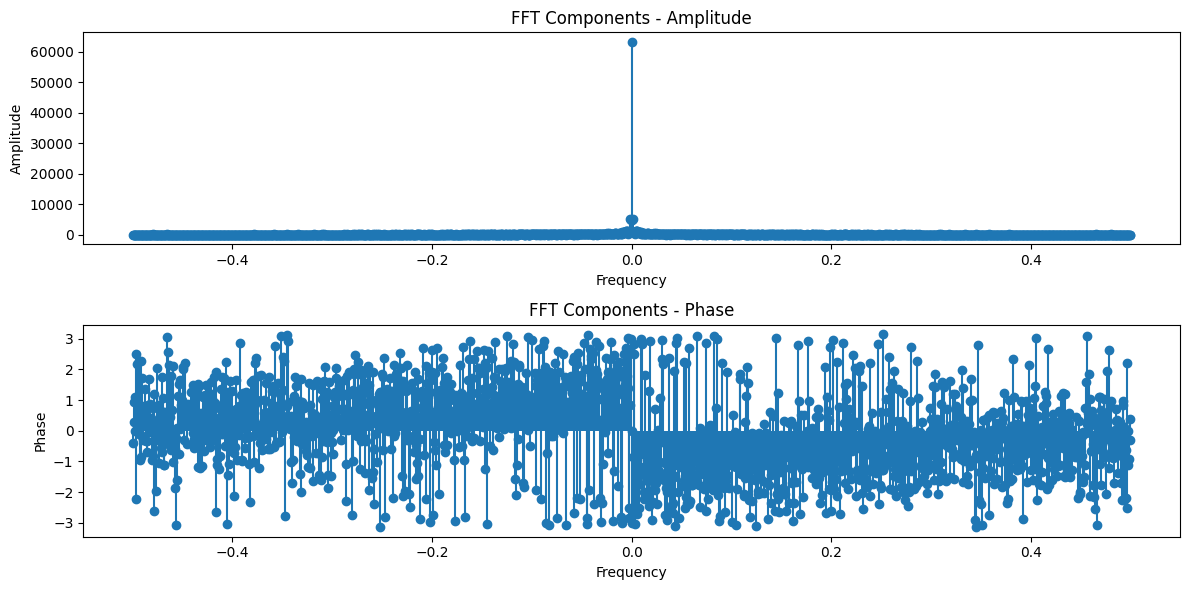

In [95]:
# Plot amplitude and phase of FFT components
amplitude = np.abs(close_prices_fft) / len(train_data)
phase = np.angle(close_prices_fft)
frequencies = np.fft.fftfreq(len(train_data))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(frequencies, amplitude, basefmt=" ")
plt.title('FFT Components - Amplitude')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.stem(frequencies, phase, basefmt=" ")
plt.title('FFT Components - Phase')
plt.xlabel('Frequency')
plt.ylabel('Phase')

plt.tight_layout()
plt.show()

In [96]:
# Discussing important mathematical concepts
nyquist_frequency = 0.5 * len(close_prices_fft) / len(train_data)
print(f'Nyquist Frequency: {nyquist_frequency}')

# Aliasing demonstration
aliasing_frequency = nyquist_frequency + 1
print(f'Aliasing Frequency: {aliasing_frequency}')

# Windowing importance
print("Windowing is important to reduce spectral leakage in the FFT. A common window function is the Hamming window.")

Nyquist Frequency: 0.5
Aliasing Frequency: 1.5
Windowing is important to reduce spectral leakage in the FFT. A common window function is the Hamming window.


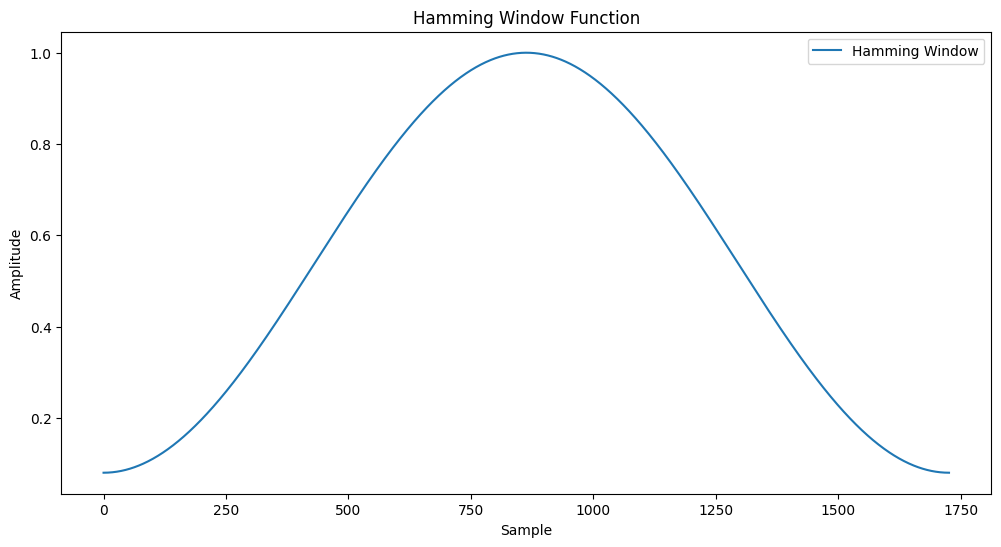

In [97]:
# Plot window function
hamming_window = np.hamming(len(train_data))
plt.figure(figsize=(12, 6))
plt.plot(hamming_window, label='Hamming Window')
plt.title('Hamming Window Function')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [98]:

# Predict the test set
num_predict = len(test_data)

test_predictions = fft_predict(data, num_predict, significant_freqs, close_prices_fft)

# Plot test set, test set forecast, and 90 days forecast
plt.figure(figsize=(12, 6))
split_index = len(train_data)
test_dates = data['Date'][split_index:]
# Calculate evaluation metrics
rmse, mae, mape = calculate_metrics(test_data['Close'].values, test_predictions)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 16528.655085987913
MAE: 15958.640666152773
MAPE: 38.379615194466815%


<Figure size 1200x600 with 0 Axes>

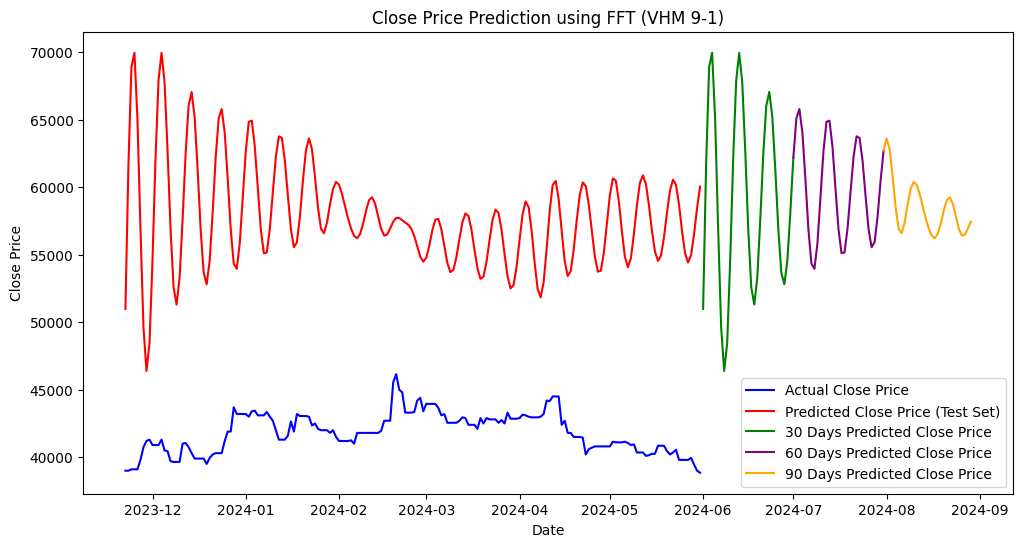

In [99]:
# Predict next 90 days since the last time of data
num_predict_future = 90

predicted_future_prices = fft_predict(data, num_predict_future, significant_freqs, close_prices_fft)
# Smooth the predicted future prices
smoothed_future_prices = smooth_signal(predicted_future_prices)
start_date = data['Date'].iloc[-1] + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_date, periods=num_predict_future)

# Plot test set, test set forecast, and 90 days forecast
plt.figure(figsize=(12, 6))
split_index = len(train_data)
test_dates = data['Date'][split_index:]
# Plot the actual test data
plt.plot(test_dates, test_data['Close'], label='Actual Close Price', color='blue')

# Plot the predicted test data
plt.plot(test_dates, test_predictions, label='Predicted Close Price (Test Set)', color='red')

# Plot the 90 days future predictions
# plt.plot(future_dates, predicted_future_prices, label='90 Days Predicted Close Price', color='orange')
# Plot the 30 days future predictions
plt.plot(future_dates[:31], predicted_future_prices[:31], label='30 Days Predicted Close Price', color='green')

# Plot the 31-60 days future predictions
plt.plot(future_dates[30:61], predicted_future_prices[30:61], label='60 Days Predicted Close Price', color='purple')

# Plot the 61-90 days future predictions
plt.plot(future_dates[60:], predicted_future_prices[60:], label='90 Days Predicted Close Price', color='orange')

plt.title('Close Price Prediction using FFT (VHM 9-1)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()